In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
# Activation functions and derivatives

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# Loss function: binary cross-entropy

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true / y_pred) + (1 - y_true) / (1 - y_pred)

In [ ]:
# Deep Neural Network with 2 hidden layers

class DeepNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, learning_rate=0.01):
        self.learning_rate = learning_rate

        # Initialize weights with He initialization for ReLU
        layer_sizes = [input_dim] + hidden_dims + [output_dim]
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(W)
            self.biases.append(b)

    def forward(self, X):
        self.zs = []  # weighted sums
        self.activations = [X]  # store activations for each layer

        for i in range(len(self.weights) - 1):
            z = self.activations[-1].dot(self.weights[i]) + self.biases[i]
            a = relu(z)
            self.zs.append(z)
            self.activations.append(a)

        # Output layer with sigmoid
        z = self.activations[-1].dot(self.weights[-1]) + self.biases[-1]
        a = sigmoid(z)
        self.zs.append(z)
        self.activations.append(a)
        return a

    def backward(self, y_true):
        m = y_true.shape[0]
        y_pred = self.activations[-1]

        # Gradient of loss w.r.t output activation
        dA = binary_cross_entropy_derivative(y_true, y_pred) / m

        self.dW = [None] * len(self.weights)
        self.db = [None] * len(self.biases)

        # Backprop for output layer (sigmoid)
        dZ = dA * sigmoid_derivative(self.zs[-1])
        self.dW[-1] = self.activations[-2].T.dot(dZ)
        self.db[-1] = np.sum(dZ, axis=0, keepdims=True)

        dA_prev = dZ.dot(self.weights[-1].T)

        # Backprop for hidden layers (ReLU)
        for i in reversed(range(len(self.weights) - 1)):
            dZ = dA_prev * relu_derivative(self.zs[i])
            self.dW[i] = self.activations[i].T.dot(dZ)
            self.db[i] = np.sum(dZ, axis=0, keepdims=True)
            dA_prev = dZ.dot(self.weights[i].T)

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.dW[i]
            self.biases[i] -= self.learning_rate * self.db[i]

    def train(self, X, y, epochs=1000, print_every=100):
        self.losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = binary_cross_entropy(y, y_pred)
            self.losses.append(loss)
            self.backward(y)
            if epoch % print_every == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

In [ ]:
# Prepare data

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
model = DeepNeuralNetwork(input_dim=2, hidden_dims=[10, 5], output_dim=1, learning_rate=0.01)
model.train(X_train, y_train, epochs=1000)

Epoch 0, Loss: 0.8247
Epoch 100, Loss: 0.5036
Epoch 200, Loss: 0.4592
Epoch 300, Loss: 0.4309
Epoch 400, Loss: 0.4095
Epoch 500, Loss: 0.3927
Epoch 600, Loss: 0.3792
Epoch 700, Loss: 0.3680
Epoch 800, Loss: 0.3587
Epoch 900, Loss: 0.3508
Epoch 999, Loss: 0.3441


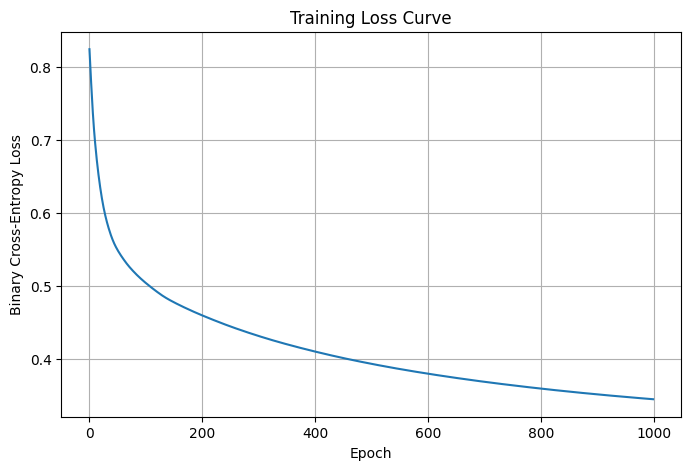

In [ ]:
# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(model.losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.grid(True)
plt.show()

In [ ]:
# Plot decision boundary function
def plot_decision_boundary(model, X, y):
    # Create mesh grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = model.predict(grid)
    preds = preds.reshape(xx.shape)

    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, preds, alpha=0.5, cmap=plt.cm.Paired)
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


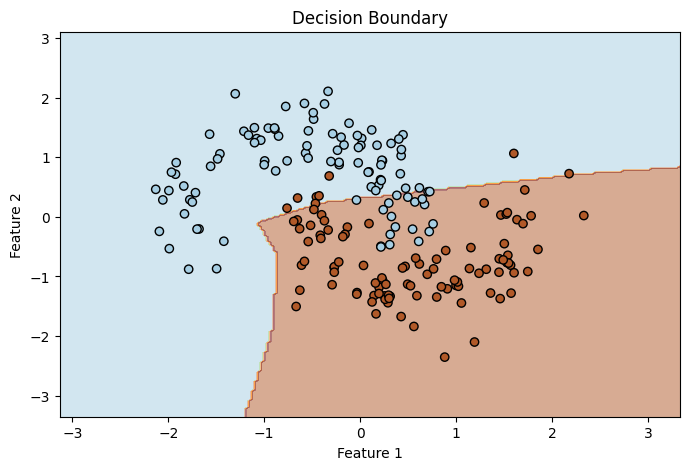

In [ ]:
# Plot decision boundary on test set
plot_decision_boundary(model, X_test, y_test)

In [ ]:
# Test accuracy
y_pred_test = model.predict(X_test)
accuracy = np.mean(y_pred_test == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 86.00%


In [ ]:
# Predict probabilities for test set (not thresholded)
y_scores = model.forward(X_test).ravel()

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

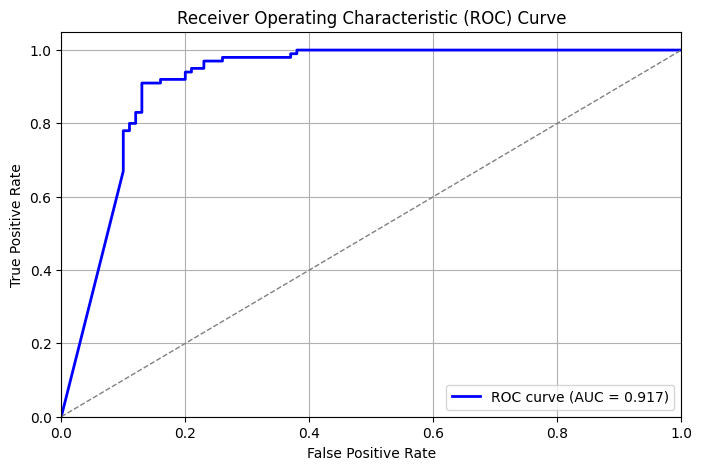

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
